# Non Performing Loan Prediction

### Contents
1. [Background, Data Description, and Problem Statement](#Background)
2. [Data Import and Preprocessing](#Data-Import-and-Preprocessing)
3. [Problem Statement](#Problem-Statement)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Data Modeling](#Data-Modeling)
6. [Conclusion and Evaluation](#Conclusion-and-Evaluation)
7. [Further Steps](#Further-Steps)

## Background 

A bank aims to predict whether a loan will be repaid to the bank. The bank is unable to accurately predict whether a client is able to pay their loan back on a continuous basis, and hence is unable to serive their clients better and prevent clients from defaulting. 
The bank's goals are to:
1. predict if a client is able to pay the installment in any given month
2. predict how much a client may be able to pay in any given period
3. accurately predict the risk of a client defaulting

## Data Description

The Berka dataset is a collection of financial information from real anonymized Czech bank transactions, account information, and loan records. The dataset consists of the following relations:

>* relation account (4500 objects in the file ACCOUNT.ASC) — each record describes static characteristics of an account.
>* relation client (5369 objects in the file CLIENT.ASC) — each record describes characteristics of a client.
>*relation disposition (5369 objects in the file DISP.ASC) — each record relates together a client with an account. i.e., this relation describes the rights of clients to operate accounts.
>*relation transaction (1056320 objects in the file TRANS.ASC) — each record describes one transaction on an account.
>*relation loan (682 objects in the file LOAN.ASC) — each record describes a loan granted for a given account.
>*relation demographic data (77 objects in the file DISTRICT.ASC) — each record describes demographic characteristics of a district.

## Problem Statement

The objective of this project is the following:
1. Predict whether or not a client will pay the loan installment for the current month
2. Predict the transaction amount a client will pay back for the current month
3. Predict the probability the client is in debt

## Solutions overview

**Assumptions**
* The dataset used contains data up to the period of December 1998. Therefore, I will build this model using data from December 1998 as the current month/target data I want to predict, and only consider data before December 1998 in my training features in order to avoid data leakage
* No information in dataset on repayment structures, so to simplify the problem I will assume all loans are term loans with a monthly repayment schedule, and base my analysis on the monthly transaction amounts from each account. If there are no transactions related to loan repayments from an account in a given month, I will assume the client has not paid the installment for the month

**Outline of problem solving structure:**
1. Data Gathering and Preprocessing: 
- I will combine the loan, transaction, account, and district data tables. 
- I will aggregate the daily transactional data to a monthly view, and remove all data related to December 1998 to avoid data leakage. 
- I will store the loan status and transactional amounts for December 1998 separately, as these will be used as the target variables for modeling. 
- Additionally, I will engineer additional features (such as average transactional amounts) that may be useful for modeling
2. Exploratory Data Analysis: 
- I have utilized the pandas profiling library for a quick summary of each feature in my final dataset

3. Modeling: 
- To solve this problem, I will first test several binary classification models predict whether a client will pay the current month’s loan installment. 
- I will then build a linear regression model to predict the amount a client will pay for the current month, using the binary classification model’s predictions as an additional feature. 
- Lastly, I will build a model to predict the probability that a client is in debt (which I will use as a metric for the risk of a client defaulting)

4. Conclusion and Evaluation: 
- I will compare the results of final models to the baseline to assess how effective my model is.

## Data Import and Preprocessing

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import time


import warnings

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve, recall_score, confusion_matrix
from matplotlib import pyplot as plt
from datetime import datetime, date, time, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import RidgeCV
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN 
from pandas_profiling import ProfileReport

### Disposition

In [2]:
# import disposition data

disp = pd.read_csv(
    "data/disp.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)

# as multiple clients can manipulate one account, create column to show if account is manipulated by owner only or deponents too
disp = pd.merge(disp,
         pd.DataFrame(disp.groupby('account_id').count()['disp_id']).reset_index().rename(columns={'disp_id':'account_partner'}),
         on = 'account_id',
         how = 'left')

# filter for account owners
disp = disp[disp.type == "OWNER"]
disp.rename(columns={"type": "type_disp"}, inplace=True)

disp.head()

disp_id  client_id  account_id type_disp  account_partner
0        1          1           1     OWNER                1
1        2          2           2     OWNER                2
3        4          4           3     OWNER                2
5        6          6           4     OWNER                1
6        7          7           5     OWNER                1

### District

In [3]:
# import district data
district = pd.read_csv(
    "data/district.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)

# A2 is district name and A3 is district region
district.drop(["A2", "A3", 'A12', 'A15'], axis=1, inplace=True)
district = district.rename(columns={'A1':'district_id'})
district.head()

district_id       A4  A5  A6  A7  A8  A9    A10    A11   A13  A14    A16
0            1  1204953   0   0   0   1   1  100.0  12541  0.43  167  99107
1            2    88884  80  26   6   2   5   46.7   8507  1.85  132   2674
2            3    75232  55  26   4   1   5   41.7   8980  2.21  111   2813
3            4   149893  63  29   6   2   6   67.4   9753  5.05  109   5892
4            5    95616  65  30   4   1   6   51.4   9307  4.43  118   3040

### Account

In [4]:
# import account data

account = pd.read_csv(
    "data/account.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
)
account.date = account.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))


frequency_dic = {
    "POPLATEK MESICNE":30, # monthly issuance
    "POPLATEK TYDNE": 7, # weekly issuance
    "POPLATEK PO OBRATU": 1 # immediate issuance
}
    
account.frequency = account.frequency.map(frequency_dic)
account.rename(columns={"frequency":"freq_statement", 'date': 'account_date'}, inplace = True)
account.drop('district_id', inplace = True, axis =1)
account.head()

account_id  freq_statement account_date
0         576              30   1993-01-01
1        3818              30   1993-01-01
2         704              30   1993-01-01
3        2378              30   1993-01-01
4        2632              30   1993-01-02

### Client

In [5]:
# import client data

client = pd.read_csv(
    "data/client.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)

# birth date month
client["month"] = client.birth_number.apply(
    lambda x: x // 100 % 100, convert_dtype=True, args=()
)

# birth date year
client["year"] = client.birth_number.apply(
    lambda x: x // 100 // 100, convert_dtype=True, args=()
)

# client age (current year is 1999)
client["age"] = 99 - client.year

# client birthdate in yymmdd (for men) and yy(mm+50)dd (for women) -> use this to find gender
client["gender"] = client.month.apply(lambda x: (x - 50) < 0, convert_dtype=True, args=())
client.gender = client.gender.astype(int)  # 0 for female, 1 for male
client.drop(["birth_number", "month", "year"], axis=1, inplace=True)
client.head()

client_id  district_id  age  gender
0          1           18   29       0
1          2            1   54       1
2          3            1   59       0
3          4            5   43       1
4          5            5   39       0

### Loan

In [6]:
# import loan dataset
loan = pd.read_csv(
    "data/loan.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)

loan.date = loan.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
loan['loan_month_year'] = loan['date'].dt.to_period('M')
loan.drop('date', axis = 1, inplace = True)

loan.rename(columns={'amount':'total_amount', 
                     'payments': 'monthly_payment',
                     'duration': 'loan_duration'},
                      inplace = True)

# filter out loans in December 1998 to avoid leakage
loan = loan[loan['loan_month_year'] != '1998-12']



# filter only status C or D (for current loans)
loan = loan[(loan.status == 'C') | (loan.status == 'D')]
loan.head()

loan_id  account_id  total_amount  loan_duration  monthly_payment status  \
23     5170        1071        253200             60           4220.0      C   
30     6087        5313        300660             60           5011.0      C   
38     7055       10079        167100             60           2785.0      C   
39     6103        5385        149340             60           2489.0      C   
42     6696        8321         89040             60           1484.0      C   

   loan_month_year  
23         1994-01  
30         1994-02  
38         1994-04  
39         1994-04  
42         1994-05

In [7]:
loan.shape

(440, 7)

### Transactions

In [8]:
# import transactions
trans = pd.read_csv(
    "data/trans.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)

operation_dic = {
    "VYBER":"withdrawal_cash",
    "PREVOD NA UCET": "remmitance_to_bank",
    "VKLAD": "credit_cash",
    "PREVOD Z UCTU": "collection_from_bank",
    "VYBER KARTOU": "withdrawal_credit_card"
}

type_dic = {
    "VYDAJ":"withdrawal",
    "VYBER": "withdrawal_cash",
    "PRIJEM": "credit"
}

k_symbol_dic = {
    "UROK": "interest_credited",
    " ": "no_symbol",
    "SLUZBY":"statement",
    "SIPO": "household",
    "DUCHOD":"pension",
    "POJISTNE": "insurance",
    "UVER": "loan",
    "SANKC. UROK":"sanction_interest",
    "LEASING": 'leasing'
}


trans.operation = trans.operation.map(operation_dic)
trans.type = trans.type.map(type_dic)
trans.k_symbol = trans.k_symbol.map(k_symbol_dic)
trans.k_symbol.fillna('no_symbol', inplace = True)
trans.drop(['bank', 'account'], axis = 1 , inplace = True)

trans.date = trans.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
trans['trans_month_year'] = trans['date'].dt.to_period('M')
trans.drop('date', axis =1, inplace = True)


trans.head()

trans_id  account_id    type    operation  amount  balance   k_symbol  \
0    695247        2378  credit  credit_cash   700.0    700.0  no_symbol   
1    171812         576  credit  credit_cash   900.0    900.0  no_symbol   
2    207264         704  credit  credit_cash  1000.0   1000.0  no_symbol   
3   1117247        3818  credit  credit_cash   600.0    600.0  no_symbol   
4    579373        1972  credit  credit_cash   400.0    400.0  no_symbol   

  trans_month_year  
0          1993-01  
1          1993-01  
2          1993-01  
3          1993-01  
4          1993-01

In [9]:
# y variable

current_amount = pd.DataFrame(loan.account_id)
current_amount = pd.merge(current_amount, 
        trans[(trans['trans_month_year'] == '1998-12') & (trans['k_symbol'] == 'loan')][['account_id','amount']].groupby('account_id').sum().reset_index(),
        on = 'account_id',
        how = 'left')
current_amount.fillna(0, inplace = True)

In [10]:
# Dec 1998 is the month I am predicting => remove datapoints from this month to avoid leakage
trans = trans[trans['trans_month_year'] != '1998-12']

In [11]:
trans[trans.k_symbol== 'no_symbol'].groupby('account_id').sum().amount

account_id
1         265266.0
2        2539024.0
3         217860.0
4          96855.0
5          28370.0
           ...    
11333    3260958.0
11349    3147526.0
11359    2611815.0
11362     994888.0
11382    2533456.0
Name: amount, Length: 4500, dtype: float64

In [12]:
# add feature for num times balance is negative to loan
loan = pd.merge(loan,
                 pd.DataFrame(trans[trans['balance']<0].groupby('account_id').count().balance).reset_index().rename(columns={'balance':'neg_balance_times'}),
                 on = 'account_id',
                 how = 'left')

# add feature for num times balance is less than 5k
loan = pd.merge(loan,
                 pd.DataFrame(trans[trans['balance']<5000].groupby('account_id').count().balance).reset_index().rename(columns={'balance':'less_than_5k_balance_times'}),
                 on = 'account_id',
                 how = 'left')

# add features for times and amounts for each transaction
for symbol in list(trans.k_symbol.value_counts().index):
    temp = pd.DataFrame(trans[trans.k_symbol== symbol].groupby('account_id').count().k_symbol).reset_index().rename(columns={'k_symbol':'times_payment_for_' + symbol})
    loan = pd.merge(loan,
                 temp,
                 on = 'account_id',
                 how = 'left')
    
for symbol in list(trans.k_symbol.value_counts().index):
    temp = pd.DataFrame(trans[trans.k_symbol== symbol].groupby('account_id').sum().amount).reset_index().rename(columns={'amount':'payment_for_' + symbol})
    loan = pd.merge(loan,
                 temp,
                 on = 'account_id',
                 how = 'left')
    

loan = loan.fillna(0)
loan.head()

loan_id  account_id  total_amount  loan_duration  monthly_payment status  \
0     5170        1071        253200             60           4220.0      C   
1     6087        5313        300660             60           5011.0      C   
2     7055       10079        167100             60           2785.0      C   
3     6103        5385        149340             60           2489.0      C   
4     6696        8321         89040             60           1484.0      C   

  loan_month_year  neg_balance_times  less_than_5k_balance_times  \
0         1994-01                0.0                         1.0   
1         1994-02                0.0                         1.0   
2         1994-04                0.0                         1.0   
3         1994-04                0.0                         1.0   
4         1994-05                0.0                         1.0   

   times_payment_for_no_symbol  ...  times_payment_for_loan  \
0                          201  ...                    58.0   
1                          284  ...                    57.0   
2                          246  ...                    56.0   
3                          176  ...                    56.0   
4                          210  ...                    55.0   

   times_payment_for_sanction_interest  payment_for_no_symbol  \
0                                  0.0              3483242.0   
1                                  0.0              4224148.0   
2                                  0.0              5126029.0   
3                                  0.0              1617350.0   
4                                  0.0              1229107.0   

   payment_for_interest_credited  payment_for_statement  \
0                        12663.1                 1920.0   
1                        12124.3                  919.8   
2                        13791.4                  963.6   
3                         8617.8                 1860.0   
4                        17576.1                  934.4   

   payment_for_household  payment_for_pension  payment_for_insurance  \
0                    0.0                  0.0                    0.0   
1               359042.0                  0.0                59396.0   
2                    0.0                  0.0                    0.0   
3               542748.0                  0.0                    0.0   
4               443583.0                  0.0                    0.0   

   payment_for_loan  payment_for_sanction_interest  
0          244731.0                            0.0  
1          285638.4                            0.0  
2          155948.8                            0.0  
3          139400.8                            0.0  
4           81620.0                            0.0  

[5 rows x 25 columns]

In [13]:
# add date of last transaction
loan = pd.merge(loan,
                 trans[trans.k_symbol == 'loan'].sort_values(by = 'trans_month_year').drop_duplicates(subset=['account_id'], keep='last')[['account_id','trans_month_year']].rename(columns={'trans_month_year':'date_last_trans'}),
                 on = 'account_id',
                 how = 'left')

# calculate duration between current month (1998-12) and last transaction
current_date = pd.to_datetime(['1998-12']).to_period('M')
loan['duration_last_trans'] = (current_date.month - loan['date_last_trans'].dt.month)
loan.drop('date_last_trans', axis = 1, inplace = True)
loan.head()

loan_id  account_id  total_amount  loan_duration  monthly_payment status  \
0     5170        1071        253200             60           4220.0      C   
1     6087        5313        300660             60           5011.0      C   
2     7055       10079        167100             60           2785.0      C   
3     6103        5385        149340             60           2489.0      C   
4     6696        8321         89040             60           1484.0      C   

  loan_month_year  neg_balance_times  less_than_5k_balance_times  \
0         1994-01                0.0                         1.0   
1         1994-02                0.0                         1.0   
2         1994-04                0.0                         1.0   
3         1994-04                0.0                         1.0   
4         1994-05                0.0                         1.0   

   times_payment_for_no_symbol  ...  times_payment_for_sanction_interest  \
0                          201  ...                                  0.0   
1                          284  ...                                  0.0   
2                          246  ...                                  0.0   
3                          176  ...                                  0.0   
4                          210  ...                                  0.0   

   payment_for_no_symbol  payment_for_interest_credited  \
0              3483242.0                        12663.1   
1              4224148.0                        12124.3   
2              5126029.0                        13791.4   
3              1617350.0                         8617.8   
4              1229107.0                        17576.1   

   payment_for_statement  payment_for_household  payment_for_pension  \
0                 1920.0                    0.0                  0.0   
1                  919.8               359042.0                  0.0   
2                  963.6                    0.0                  0.0   
3                 1860.0               542748.0                  0.0   
4                  934.4               443583.0                  0.0   

   payment_for_insurance  payment_for_loan  payment_for_sanction_interest  \
0                    0.0          244731.0                            0.0   
1                59396.0          285638.4                            0.0   
2                    0.0          155948.8                            0.0   
3                    0.0          139400.8                            0.0   
4                    0.0           81620.0                            0.0   

   duration_last_trans  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  

[5 rows x 26 columns]

In [14]:
# add number of loan transactions
loan = pd.merge(loan,
         trans[trans.k_symbol == 'loan'].groupby('account_id').count().reset_index()[['account_id', 'trans_id']].rename(columns={'trans_id':'num_loan_trans'}),
         on = 'account_id',
         how = 'left')

loan.head()

loan_id  account_id  total_amount  loan_duration  monthly_payment status  \
0     5170        1071        253200             60           4220.0      C   
1     6087        5313        300660             60           5011.0      C   
2     7055       10079        167100             60           2785.0      C   
3     6103        5385        149340             60           2489.0      C   
4     6696        8321         89040             60           1484.0      C   

  loan_month_year  neg_balance_times  less_than_5k_balance_times  \
0         1994-01                0.0                         1.0   
1         1994-02                0.0                         1.0   
2         1994-04                0.0                         1.0   
3         1994-04                0.0                         1.0   
4         1994-05                0.0                         1.0   

   times_payment_for_no_symbol  ...  payment_for_no_symbol  \
0                          201  ...              3483242.0   
1                          284  ...              4224148.0   
2                          246  ...              5126029.0   
3                          176  ...              1617350.0   
4                          210  ...              1229107.0   

   payment_for_interest_credited  payment_for_statement  \
0                        12663.1                 1920.0   
1                        12124.3                  919.8   
2                        13791.4                  963.6   
3                         8617.8                 1860.0   
4                        17576.1                  934.4   

   payment_for_household  payment_for_pension  payment_for_insurance  \
0                    0.0                  0.0                    0.0   
1               359042.0                  0.0                59396.0   
2                    0.0                  0.0                    0.0   
3               542748.0                  0.0                    0.0   
4               443583.0                  0.0                    0.0   

   payment_for_loan  payment_for_sanction_interest  duration_last_trans  \
0          244731.0                            0.0                    1   
1          285638.4                            0.0                    1   
2          155948.8                            0.0                    1   
3          139400.8                            0.0                    1   
4           81620.0                            0.0                    1   

   num_loan_trans  
0            58.0  
1            57.0  
2            56.0  
3            56.0  
4            55.0  

[5 rows x 27 columns]

In [15]:
# create pivot table with loan transaction amounts per account

loan_trans = trans[trans.k_symbol == 'loan']
amount_pv = loan_trans.pivot_table(values=['amount'],index = 'account_id', columns = ['trans_month_year'])
amount_pv.fillna(0, inplace=True)


amount_pv = amount_pv.reset_index()

amount_pv.columns = [ '_'.join([str(c) for c in c_list]) for c_list in amount_pv.columns.values ]
amount_pv.rename(columns={'account_id_':'account_id'}, inplace = True)

amount_pv.head()

account_id  amount_1993-07  amount_1993-08  amount_1993-09  amount_1993-10  \
0           2             0.0             0.0             0.0             0.0   
1          19             0.0             0.0             0.0             0.0   
2          25             0.0             0.0             0.0             0.0   
3          37             0.0             0.0             0.0             0.0   
4          38             0.0             0.0             0.0             0.0   

   amount_1993-11  amount_1993-12  amount_1994-01  amount_1994-02  \
0             0.0             0.0          3372.7          3372.7   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   amount_1994-03  ...  amount_1998-02  amount_1998-03  amount_1998-04  \
0          3372.7  ...             0.0             0.0             0.0   
1             0.0  ...             0.0             0.0             0.0   
2             0.0  ...          2523.2          2523.2          2523.2   
3             0.0  ...             0.0             0.0             0.0   
4             0.0  ...             0.0             0.0             0.0   

   amount_1998-05  amount_1998-06  amount_1998-07  amount_1998-08  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2          2523.2          2523.2          2523.2          2523.2   
3             0.0             0.0             0.0             0.0   
4          2306.8          2306.8          2306.8          2306.8   

   amount_1998-09  amount_1998-10  amount_1998-11  
0             0.0             0.0             0.0  
1             0.0             0.0             0.0  
2          2523.2          2523.2          2523.2  
3             0.0             0.0          5307.5  
4          2306.8          2306.8          2306.8  

[5 rows x 66 columns]

In [16]:
# create features for amount
amounts = pd.DataFrame()
amounts['account_id'] = amount_pv['account_id']
amounts['1M_lag_amount'] = amount_pv['amount_1998-11']
amounts['2M_lag_amount'] = amount_pv['amount_1998-10']
amounts['3M_lag_amount'] = amount_pv['amount_1998-09']
amounts['4M_lag_amount'] = amount_pv['amount_1998-08']
amounts['5M_lag_amount'] = amount_pv['amount_1998-07']
amounts['6M_lag_amount'] = amount_pv['amount_1998-06']
amounts['3M_avg_amount'] = amount_pv[amount_pv.columns[-3:]].mean(axis = 1)
amounts['6M_avg_amount'] = amount_pv[amount_pv.columns[-6:]].mean(axis = 1)
amounts['1Y_avg_amount'] = amount_pv[amount_pv.columns[-12:]].mean(axis = 1)

In [17]:
amounts.head()

account_id  1M_lag_amount  2M_lag_amount  3M_lag_amount  4M_lag_amount  \
0           2            0.0            0.0            0.0            0.0   
1          19            0.0            0.0            0.0            0.0   
2          25         2523.2         2523.2         2523.2         2523.2   
3          37         5307.5            0.0            0.0            0.0   
4          38         2306.8         2306.8         2306.8         2306.8   

   5M_lag_amount  6M_lag_amount  3M_avg_amount  6M_avg_amount  1Y_avg_amount  
0            0.0            0.0       0.000000       0.000000       0.000000  
1            0.0            0.0       0.000000       0.000000       0.000000  
2         2523.2         2523.2    2523.200000    2523.200000    2523.200000  
3            0.0            0.0    1769.166667     884.583333     442.291667  
4         2306.8         2306.8    2306.800000    2306.800000    1345.633333

In [18]:
# create pivot table with loan transaction balance per account
balance_pv = loan_trans.pivot_table(values=['balance'],index = 'account_id', columns = ['trans_month_year'])
balance_pv.fillna(0, inplace=True)
balance_pv = balance_pv.reset_index()

balance_pv.columns = [ '_'.join([str(c) for c in c_list]) for c_list in balance_pv.columns.values ]
balance_pv.rename(columns={'account_id_':'account_id'}, inplace = True)

balance_pv.head()

account_id  balance_1993-07  balance_1993-08  balance_1993-09  \
0           2              0.0              0.0              0.0   
1          19              0.0              0.0              0.0   
2          25              0.0              0.0              0.0   
3          37              0.0              0.0              0.0   
4          38              0.0              0.0              0.0   

   balance_1993-10  balance_1993-11  balance_1993-12  balance_1994-01  \
0              0.0              0.0              0.0          35337.9   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   balance_1994-02  balance_1994-03  ...  balance_1998-02  balance_1998-03  \
0          29636.0          35826.9  ...              0.0              0.0   
1              0.0              0.0  ...              0.0              0.0   
2              0.0              0.0  ...          44822.4          19352.2   
3              0.0              0.0  ...              0.0              0.0   
4              0.0              0.0  ...              0.0              0.0   

   balance_1998-04  balance_1998-05  balance_1998-06  balance_1998-07  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2           8815.8          61569.8          59026.9          64795.2   
3              0.0              0.0              0.0              0.0   
4              0.0          30096.9          45478.0          42295.9   

   balance_1998-08  balance_1998-09  balance_1998-10  balance_1998-11  
0              0.0              0.0              0.0              0.0  
1              0.0              0.0              0.0              0.0  
2          62591.5          49182.7          20001.1          27886.5  
3              0.0              0.0              0.0           6140.0  
4          42758.5          32071.6          40553.8          43158.2  

[5 rows x 66 columns]

In [19]:
# create features for balance
balance = pd.DataFrame()
balance['account_id'] = balance_pv['account_id']
balance['1M_lag_balance'] = balance_pv['balance_1998-11']
balance['2M_lag_balance'] = balance_pv['balance_1998-10']
balance['3M_lag_balance'] = balance_pv['balance_1998-09']
balance['4M_lag_balance'] = balance_pv['balance_1998-08']
balance['5M_lag_balance'] = balance_pv['balance_1998-07']
balance['6M_lag_balance'] = balance_pv['balance_1998-06']
balance['3M_avg_balance'] = balance_pv[balance_pv.columns[-3:]].mean(axis = 1)
balance['6M_avg_balance'] = balance_pv[balance_pv.columns[-6:]].mean(axis = 1)
balance['1Y_avg_balance'] = balance_pv[balance_pv.columns[-12:]].mean(axis = 1)

In [20]:
balance.head()

account_id  1M_lag_balance  2M_lag_balance  3M_lag_balance  4M_lag_balance  \
0           2             0.0             0.0             0.0             0.0   
1          19             0.0             0.0             0.0             0.0   
2          25         27886.5         20001.1         49182.7         62591.5   
3          37          6140.0             0.0             0.0             0.0   
4          38         43158.2         40553.8         32071.6         42758.5   

   5M_lag_balance  6M_lag_balance  3M_avg_balance  6M_avg_balance  \
0             0.0             0.0        0.000000        0.000000   
1             0.0             0.0        0.000000        0.000000   
2         64795.2         59026.9    32356.766667    47247.316667   
3             0.0             0.0     2046.666667     1023.333333   
4         42295.9         45478.0    38594.533333    41052.666667   

   1Y_avg_balance  
0        0.000000  
1        0.000000  
2    37412.941667  
3      511.666667  
4    23034.408333

In [21]:
transaction_data = pd.merge(amounts, balance, on = 'account_id')
transaction_data.head()

account_id  1M_lag_amount  2M_lag_amount  3M_lag_amount  4M_lag_amount  \
0           2            0.0            0.0            0.0            0.0   
1          19            0.0            0.0            0.0            0.0   
2          25         2523.2         2523.2         2523.2         2523.2   
3          37         5307.5            0.0            0.0            0.0   
4          38         2306.8         2306.8         2306.8         2306.8   

   5M_lag_amount  6M_lag_amount  3M_avg_amount  6M_avg_amount  1Y_avg_amount  \
0            0.0            0.0       0.000000       0.000000       0.000000   
1            0.0            0.0       0.000000       0.000000       0.000000   
2         2523.2         2523.2    2523.200000    2523.200000    2523.200000   
3            0.0            0.0    1769.166667     884.583333     442.291667   
4         2306.8         2306.8    2306.800000    2306.800000    1345.633333   

   1M_lag_balance  2M_lag_balance  3M_lag_balance  4M_lag_balance  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2         27886.5         20001.1         49182.7         62591.5   
3          6140.0             0.0             0.0             0.0   
4         43158.2         40553.8         32071.6         42758.5   

   5M_lag_balance  6M_lag_balance  3M_avg_balance  6M_avg_balance  \
0             0.0             0.0        0.000000        0.000000   
1             0.0             0.0        0.000000        0.000000   
2         64795.2         59026.9    32356.766667    47247.316667   
3             0.0             0.0     2046.666667     1023.333333   
4         42295.9         45478.0    38594.533333    41052.666667   

   1Y_avg_balance  
0        0.000000  
1        0.000000  
2    37412.941667  
3      511.666667  
4    23034.408333

In [22]:
# merge dataframes

# loan and transactions
df_final = pd.merge(loan, transaction_data, on ='account_id', how = 'left')
df_final = df_final.fillna(0)

# current amount
df_final = pd.merge(df_final, current_amount, on ='account_id', how = 'left')
df_final = df_final.fillna(0)

# df_final and disp
df_final = pd.merge(df_final, disp, on ='account_id', how = 'left')

# df_final and client
df_final = pd.merge(df_final, client, on ='client_id', how = 'left')

# df_final and district
df_final = pd.merge(df_final, district, on ='district_id', how = 'left')

# df_final and account
df_final = pd.merge(df_final, account, on ='account_id', how = 'left')

df_final.head()

loan_id  account_id  total_amount  loan_duration  monthly_payment status  \
0     5170        1071        253200             60           4220.0      C   
1     6087        5313        300660             60           5011.0      C   
2     7055       10079        167100             60           2785.0      C   
3     6103        5385        149340             60           2489.0      C   
4     6696        8321         89040             60           1484.0      C   

  loan_month_year  neg_balance_times  less_than_5k_balance_times  \
0         1994-01                0.0                         1.0   
1         1994-02                0.0                         1.0   
2         1994-04                0.0                         1.0   
3         1994-04                0.0                         1.0   
4         1994-05                0.0                         1.0   

   times_payment_for_no_symbol  ...  A7  A8  A9   A10   A11   A13  A14   A16  \
0                          201  ...   8   3  10  61.9  8363  3.49  108  2799   
1                          284  ...   6   3   8  85.3  9317  7.07   97  6872   
2                          246  ...  13   2   5  40.7  8544  1.86  109  2906   
3                          176  ...   7   2   7  53.0  8254  3.76   97  2325   
4                          210  ...  12   3   4  53.5  8909  5.56  113  3590   

   freq_statement  account_date  
0               7    1993-05-10  
1              30    1993-04-29  
2              30    1993-05-06  
3               7    1993-05-21  
4              30    1993-04-12  

[5 rows x 66 columns]

In [23]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 66 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   loan_id                              440 non-null    int64         
 1   account_id                           440 non-null    int64         
 2   total_amount                         440 non-null    int64         
 3   loan_duration                        440 non-null    int64         
 4   monthly_payment                      440 non-null    float64       
 5   status                               440 non-null    object        
 6   loan_month_year                      440 non-null    period[M]     
 7   neg_balance_times                    440 non-null    float64       
 8   less_than_5k_balance_times           440 non-null    float64       
 9   times_payment_for_no_symbol          440 non-null    int64         
 10  times_payment_

In [24]:
# years of loan
df_final["year_"] = df_final.loan_month_year.apply(lambda x: x.year, convert_dtype=int, args=())
df_final["years_of_loan"] = 1999 - df_final.year_
df_final.drop(["loan_month_year", "year_"], axis=1 , inplace=True)

# years of account
df_final["year_"] = df_final.account_date.apply(lambda x: x.year, convert_dtype=int, args=())
df_final["years_of_account"] = 1999 - df_final.year_
df_final.drop(["account_date", "year_", "type_disp"], axis=1, inplace=True)

In [25]:
# drop unnecessary columns
df_final.drop(['account_id',
               'disp_id',
               'client_id',
               'district_id'
              ], axis = 1, inplace = True)

In [26]:
#create new feature for if loan is paid
df_final['not_paid'] = df_final['amount'].apply(lambda x: 0 if x != 0 else 1)

# one hot encode status
df_final['status'] = df_final['status'].map({'C':0, 'D': 1})


In [27]:
df_final.columns

Index(['loan_id', 'total_amount', 'loan_duration', 'monthly_payment', 'status',
       'neg_balance_times', 'less_than_5k_balance_times',
       'times_payment_for_no_symbol', 'times_payment_for_interest_credited',
       'times_payment_for_statement', 'times_payment_for_household',
       'times_payment_for_pension', 'times_payment_for_insurance',
       'times_payment_for_loan', 'times_payment_for_sanction_interest',
       'payment_for_no_symbol', 'payment_for_interest_credited',
       'payment_for_statement', 'payment_for_household', 'payment_for_pension',
       'payment_for_insurance', 'payment_for_loan',
       'payment_for_sanction_interest', 'duration_last_trans',
       'num_loan_trans', '1M_lag_amount', '2M_lag_amount', '3M_lag_amount',
       '4M_lag_amount', '5M_lag_amount', '6M_lag_amount', '3M_avg_amount',
       '6M_avg_amount', '1Y_avg_amount', '1M_lag_balance', '2M_lag_balance',
       '3M_lag_balance', '4M_lag_balance', '5M_lag_balance', '6M_lag_balance',
       '3M

## Exploratory Data Analysis

In [28]:
# use pandas profiling

prof = ProfileReport(df_final, minimal=True)
# prof.to_file(output_file='results/EDA.html')
prof.to_notebook_iframe()

**Observations from pandas profiling:**
* Minimum loan size is 5K and maximum is 590K. The minimum monthly installment due is 0.3K, and maximum is 9.9K.
* Most loans in the dataset are 5Y loans (140 loans), and least are 1Y loans (27 loans)
* The data set is highly imbalanced - if looking at whether or not a client has paid an installment in December 1998, 97% of clients have paid an installment and only 3% have not. Additonally, 90% of loans are running with no issue, and 10% of outstanding loans have clients that are in debt. 
* 10% of loans belong to accounnts that have previously had a negative balance. The maximum number of times a single account has had a negative balance is 117 times
* 98.5% of loans belong to accounts that have previoulsy had less than 5K balance. The maximum number of times a single account has had a balance under 5K is 183 times
* Most outstanding loans are 1-2 years old. Most accounts are 3 years old.
* 51% of the outstanding loans are with female clients
* There is a positive correlation between whether or not the client paid an installment in December 1998 and the number of times the account had a negative balance, the number of times the account had a balance less than 5K, and the duration since the last loan transaction. 
* There is a negative correlation between whether or not the client paid an installment in December 1998 and the account balance for November 1998, the previous 3 month average account balance, and the total size of the loan
* Many of the features (such as the loan installment amounts for the last few months) are highly correlated - I may need to use methods for feature selection when modeling

## Data Modeling

The goal of this project is to be able to predict whether an installment for the next month will be paid: 
True means the installment has not been paid, False means the installment has been paid.

This means that:
>* True Positives are loans where my model correctly predicts that the installment has not been paid
>* True Negatives are loans where my model correctly predicts that the installment has been paid
>* False Positves are loans where my model incorrectly predicts that the installment has not been paid (but it actually has been paid)
>* False Negatives are loans where my model incorrectly predicts that the installment has been paid (but it actually has not been paid)

While ideally I would want to accurately predict all installment payments correctly, in the case of NPLs a False Negative is a bigger liquidity risk for the bank than a False Positive since predicting installments have been paid when they have not could lead to a shortage in short term liquidity (whereas a False Negative would mean excess cash). Therefore, I want to focus on minimiizing my False Negative Rate (or maximizing the recall score).

### Pre-processing

In [29]:
# create copy of final dataframe
df = df_final.copy()

In [30]:
# view columns
df.columns

Index(['loan_id', 'total_amount', 'loan_duration', 'monthly_payment', 'status',
       'neg_balance_times', 'less_than_5k_balance_times',
       'times_payment_for_no_symbol', 'times_payment_for_interest_credited',
       'times_payment_for_statement', 'times_payment_for_household',
       'times_payment_for_pension', 'times_payment_for_insurance',
       'times_payment_for_loan', 'times_payment_for_sanction_interest',
       'payment_for_no_symbol', 'payment_for_interest_credited',
       'payment_for_statement', 'payment_for_household', 'payment_for_pension',
       'payment_for_insurance', 'payment_for_loan',
       'payment_for_sanction_interest', 'duration_last_trans',
       'num_loan_trans', '1M_lag_amount', '2M_lag_amount', '3M_lag_amount',
       '4M_lag_amount', '5M_lag_amount', '6M_lag_amount', '3M_avg_amount',
       '6M_avg_amount', '1Y_avg_amount', '1M_lag_balance', '2M_lag_balance',
       '3M_lag_balance', '4M_lag_balance', '5M_lag_balance', '6M_lag_balance',
       '3M

In [31]:
# drop unnecessary columns
df.drop(
    ["loan_id",
     "status", #cannot use current status to predict if installment is paid
     "amount" # cannot use current month's amount paid to predict if current installment is paid
    ],
    axis=1,
    inplace=True,
)

In [32]:
# train-test split

X = df.loc[:, df.columns != "not_paid"]
y = df.loc[:, "not_paid"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state = 42)

### Define functions

In [33]:
# define functions for modeling

# compare recall
def display_recall(model, X_train, y_train, X_test, y_test):
    print('Train Recall Score: ', round(recall_score(y_train, model.predict(X_train), zero_division=0),5))
    print('Test Recall Score: ', round(recall_score(y_test, model.predict(X_test), zero_division=0),5))
    
# plot ROC and Confusion matrix
def plot_model(model, X_test, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    
    #Plot ROC curve
    ax1.set_title('ROC Curve')
    plot_roc_curve(model, X_test, y_test, ax = ax1)
    ax1.plot([0, 1], [0, 1],label='baseline', linestyle='--')
    ax1.legend()

    #Plot confusion matrix
    ax2.set_title('Confusion Matrix')
    y_pred = pd.Series(model.predict(X_test))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax2, cmap='Blues')
    ax2.set_xlabel('Predicted labels')
    ax2.set_ylabel('True labels')
    plt.show();

# model comparisons
def add_model(name, model, X_test, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    
    model_dictionary[name] = [round(f1_score(y_test, model.predict(X_test), zero_division=0),5), #F1 score
                              round(recall_score(y_test, model.predict(X_test), zero_division=0),5), #Recall 
                              round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),5), #ROC AUC 
                              tp, #True Positive
                              fp, #False Positive
                              tn, #True Negative
                              fn #False Negative
                             ]
    return pd.DataFrame.from_dict(model_dictionary, orient = 'index', columns=['F1 Score', 'Recall', 'ROC AUC', 'True Positives', 'False Positives','True Negatives','False Negatives'])


def metrics_heatmap(model_dic):
    plt.figure(figsize = (12,12))
    return sns.heatmap(pd.DataFrame.from_dict(model_dictionary, orient = 'index', columns=['F1 Score', 'Recall', 'ROC AUC', 'True Positives', 'False Positives','True Negatives','False Negatives'])[['F1 Score', 'Recall', 'ROC AUC']],
                       annot = True)
                                          
    

### Baseline

- The baseline is the simplest model I could use to predict if a loan installment for the current month has been paid. 
- If I look at the distribution of my target variable, only 3% of loan installments have not been paid in December. Therefore, my simplest model would be to say there is a 97% chance a client will pay the loan installment in any given month. 
- I will build this model and calculate my metrics for comparison

In [34]:
# create baseline dataframe
df_baseline = pd.DataFrame(y_test.values, columns=['y_true'])
df_baseline['y_pred'] = np.random.choice([0,1], p = [.97,.03], size = len(df_baseline))
df_baseline['y_pred_prob'] = 0.03

df_baseline.head()

y_true  y_pred  y_pred_prob
0       0       0         0.03
1       0       0         0.03
2       0       0         0.03
3       0       0         0.03
4       0       0         0.03

In [35]:
# create model dictionary to compare future models to baseline
model_dictionary = {'Baseline':
                    [round(f1_score(df_baseline['y_true'],df_baseline['y_pred']),5), #F1 score
                     recall_score(df_baseline['y_true'],df_baseline['y_pred']), # recall score
                     roc_auc_score(df_baseline['y_true'], df_baseline['y_pred_prob']), #ROC AUC score
                     ((df_baseline['y_pred']==1) & (df_baseline['y_true']==1)).sum(), #True Positive
                     ((df_baseline['y_pred']==1) & (df_baseline['y_true']==0)).sum(), #False Positive
                     ((df_baseline['y_pred']==0) & (df_baseline['y_true']==0)).sum(), #True Negative
                     ((df_baseline['y_pred']==0) & (df_baseline['y_true']==1)).sum() ]} #False Negative 

### Random Forest (default)

- The first model I will build is a random forest
- A random forest algorithm consists of a large number of individual decision trees that operate as an ensemble. Each tree is trained using a random subset of features at each split, and using a bootstrapped sample of the data. Every tree will make its own prediction for whether or not an installment is paid, and the final prediction will be the class with the most votes. 

In [36]:
clf = RandomForestClassifier(random_state=10)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

In [37]:
display_recall(clf,X_train, y_train, X_test, y_test)

Train Recall Score:  1.0
Test Recall Score:  0.75


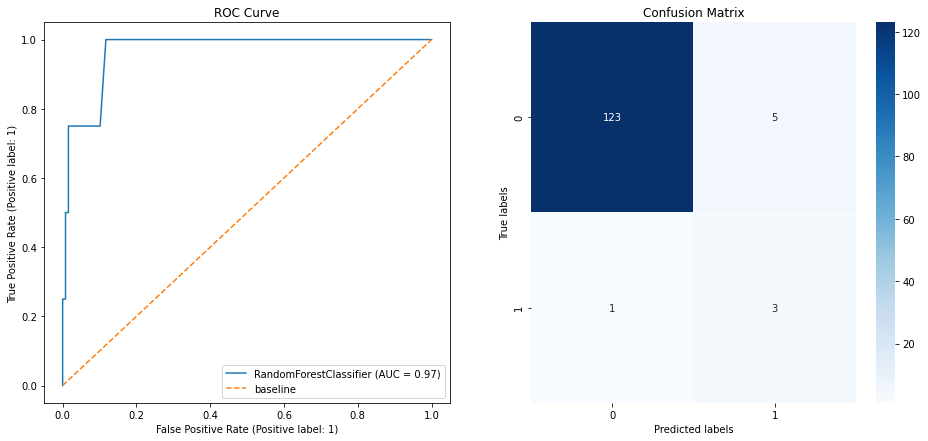

In [38]:
plot_model(clf, X_test, y_test)

In [39]:
add_model('Random Forest (default)', clf, X_test, y_test)

F1 Score  Recall  ROC AUC  True Positives  \
Baseline                      0.0    0.00   0.5000               0   
Random Forest (default)       0.5    0.75   0.9668               3   

                         False Positives  True Negatives  False Negatives  
Baseline                               4             124                4  
Random Forest (default)                5             123                1

### Random Forest with HyperParameter Tuning

In [40]:
#fit model
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

clf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=params, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), scoring='recall')
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=RandomForestClassifier(random_state=10),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='recall')

In [41]:
display_recall(clf,X_train, y_train, X_test, y_test)

Train Recall Score:  1.0
Test Recall Score:  0.75


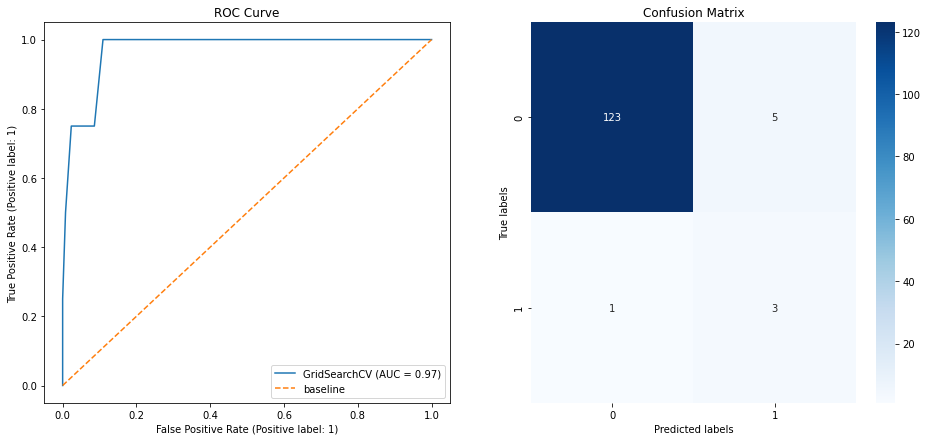

In [42]:
plot_model(clf, X_test, y_test)

In [43]:
add_model('Random Forest (with tuning)', clf, X_test, y_test)

F1 Score  Recall  ROC AUC  True Positives  \
Baseline                          0.0    0.00   0.5000               0   
Random Forest (default)           0.5    0.75   0.9668               3   
Random Forest (with tuning)       0.5    0.75   0.9707               3   

                             False Positives  True Negatives  False Negatives  
Baseline                                   4             124                4  
Random Forest (default)                    5             123                1  
Random Forest (with tuning)                5             123                1

In [44]:
# save best estimator

rf_best = clf.best_estimator_


### Random Forest with Oversampling

- I will try to address the class imbalance by using ADASYN, an oversampling technique. ADASYN stands for Adaptive Synthetic Sampling Method, and is a way to create synthetic data points for the minority class (in this case, it will create synthetic data points where loan installments are not paid). ADASYN looks at the density distribution of the data to determine the number of samples that will be generated around each data point.

In [45]:
# use ADASYN for oversampling

sm = ADASYN(random_state = 42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# scale data
ss = StandardScaler()
X_train_resampled_scaled = ss.fit_transform(X_train_resampled)
X_test_scaled = ss.transform(X_test)

#fit model
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

clf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=params, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), scoring='recall')
clf.fit(X_train_resampled_scaled, y_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=RandomForestClassifier(random_state=10),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='recall')

In [46]:
display_recall(clf,X_train_resampled_scaled, y_train_resampled, X_test_scaled, y_test)

Train Recall Score:  1.0
Test Recall Score:  0.5


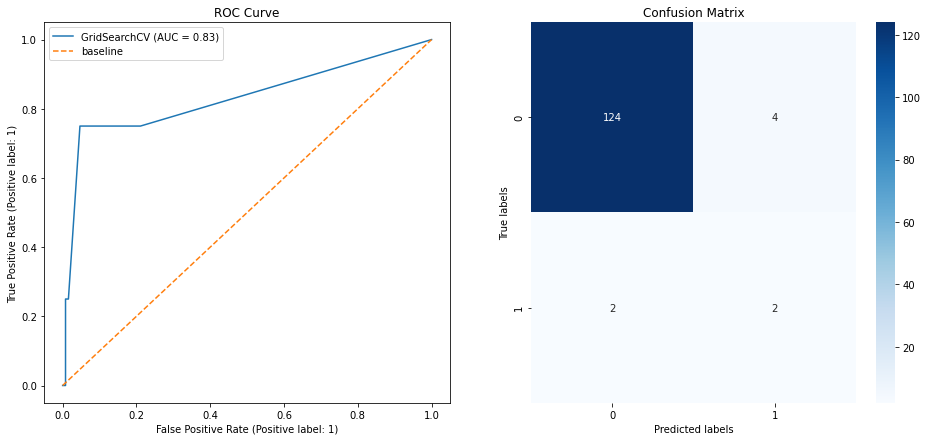

In [47]:
plot_model(clf, X_test_scaled, y_test)

In [48]:
add_model('Random Forest (with oversampling)', clf, X_test_scaled, y_test)

F1 Score  Recall  ROC AUC  True Positives  \
Baseline                                0.0    0.00  0.50000               0   
Random Forest (default)                 0.5    0.75  0.96680               3   
Random Forest (with tuning)             0.5    0.75  0.97070               3   
Random Forest (with oversampling)       0.4    0.50  0.83105               2   

                                   False Positives  True Negatives  \
Baseline                                         4             124   
Random Forest (default)                          5             123   
Random Forest (with tuning)                      5             123   
Random Forest (with oversampling)                4             124   

                                   False Negatives  
Baseline                                         4  
Random Forest (default)                          1  
Random Forest (with tuning)                      1  
Random Forest (with oversampling)                2

## Logistic Regression with Hyperparameter Tuning

* For comparison, I will try building a logistic regression model
* Since hyperparameter tuning helped the random forest model perform better, but oversampling did not, I will implement only hyperparameter tuning to my model

In [49]:
#fit model
params = { 'penalty': ['l1','l2'],
           'C': [0.1, 0.5, 1.0],
           'solver': ['liblinear']
}

clf = GridSearchCV(LogisticRegression(random_state=10), param_grid=params, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), scoring='recall')


ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=LogisticRegression(random_state=10),
             param_grid={'C': [0.1, 0.5, 1.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='recall')

In [50]:
display_recall(clf,X_train_scaled, y_train, X_test_scaled, y_test)

Train Recall Score:  0.5
Test Recall Score:  0.75


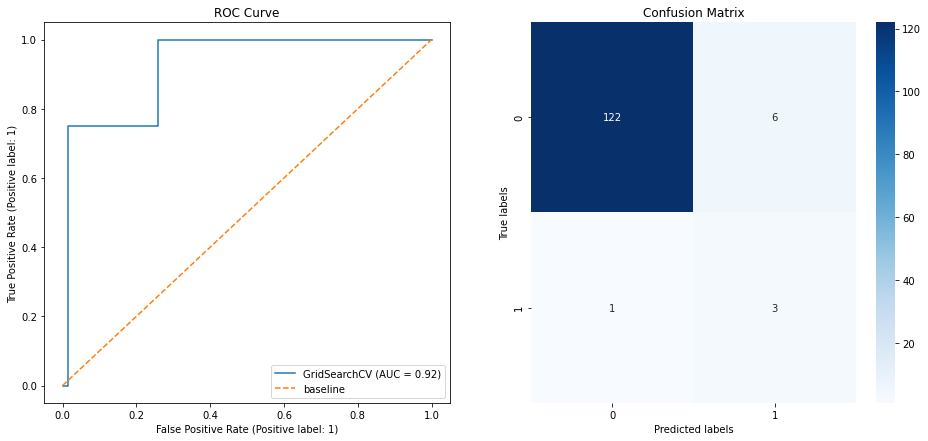

In [51]:
plot_model(clf, X_test_scaled, y_test)

In [52]:
add_model('Logistic Regression (with tuning)', clf, X_test_scaled, y_test)

F1 Score  Recall  ROC AUC  True Positives  \
Baseline                            0.00000    0.00  0.50000               0   
Random Forest (default)             0.50000    0.75  0.96680               3   
Random Forest (with tuning)         0.50000    0.75  0.97070               3   
Random Forest (with oversampling)   0.40000    0.50  0.83105               2   
Logistic Regression (with tuning)   0.46154    0.75  0.92383               3   

                                   False Positives  True Negatives  \
Baseline                                         4             124   
Random Forest (default)                          5             123   
Random Forest (with tuning)                      5             123   
Random Forest (with oversampling)                4             124   
Logistic Regression (with tuning)                6             122   

                                   False Negatives  
Baseline                                         4  
Random Forest (default)                          1  
Random Forest (with tuning)                      1  
Random Forest (with oversampling)                2  
Logistic Regression (with tuning)                1

<AxesSubplot:>

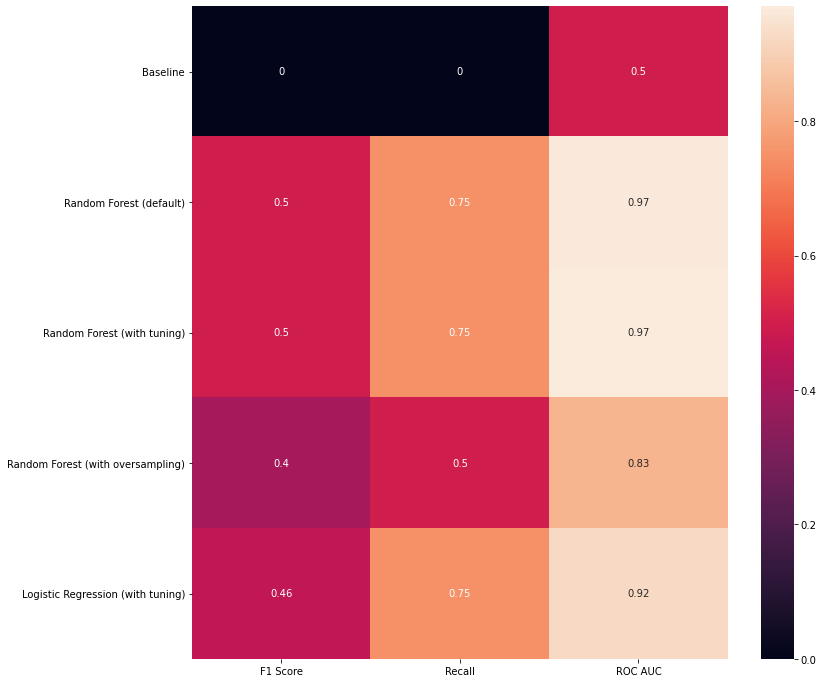

In [53]:
metrics_heatmap(model_dictionary)

## Predict Current Amount 

- For this part, I will build a linear regression model. I will input my prediction for whether or not the client pays the loan installment for the month as a feature

In [54]:
### Use Random forest to create new feature

##preprocessing for random forest
df_temp = df_final.copy()
df_with_pred = df_final.copy()

# drop unnecessary columns
df_temp.drop(
    ["loan_id",
     "status", #cannot use current status to predict if installment is paid
     "amount", # cannot use current amount to predict if installment is paid
     "not_paid" # use random forest to predict this feature
    ],
    axis=1,
    inplace=True,
)

ss = StandardScaler()
X_scaled = ss.fit_transform(df_temp)
df_with_pred['prob_repay'] = rf_best.predict_proba(X_scaled)[:,1]

In [55]:

df = df_with_pred.copy()
# drop unnecessary columns
df.drop(
    ["loan_id",
     "status", #cannot use current status to predict if installment is paid
     "not_paid" # used random forest to predict this feature
    ],
    axis=1,
    inplace=True,
)

# train-test split
X = df.loc[:, df.columns != "amount"]
y = df.loc[:, "amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# scale data
# instantiate standard scaler
ss = StandardScaler()

# fit standard scaler on train set
X_train_ss = ss.fit_transform(X_train)

# transform test set 
X_test_ss = ss.transform(X_test)

### Linear Ridge Regression

In [56]:
# Ridge Regression

# choose values of alpha to train
r_alphas = np.logspace(0, 5, 100)

# instantiate ridgeCV
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# fit ridgeCV to train data
ridge_cv = ridge_cv.fit(X_train_ss, y_train)

In [57]:
def display_r2(model, X_train, y_train, X_test, y_test):
    print('Train Score: ', round(model.score(X_train,y_train),7))
    print('Test Score: ', round(model.score(X_test, y_test),7))
    print('Cross Val Score:', round(cross_val_score(model, X_test,y_test).mean(),7))
    
display_r2(ridge_cv, X_train_ss, y_train, X_test_ss, y_test)

Train Score:  0.9593099
Test Score:  0.766416
Cross Val Score: 0.8178448


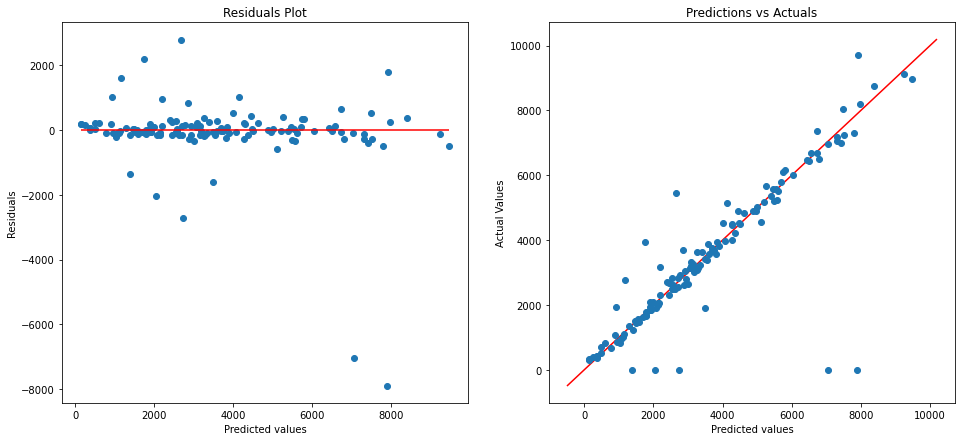

In [58]:
# plot residuals and prediction vs actual
def plot_pred(pred, y_test):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    
    #Plot Residuals
    ax1.set_title('Residuals Plot')
    ax1.set(xlabel='Predicted values', ylabel='Residuals')
    ax1.scatter(pred, y_test - pred)
    ax1.hlines(y = 0, xmin = min(pred), xmax = max(pred), colors='red', linestyles='solid')
    
    #Plot Predictions
    ax2.set_title('Predictions vs Actuals')
    ax2.set(xlabel='Predicted values', ylabel='Actual Values')
    ax2.scatter(pred, y_test)
    
    lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
    ]
    
    ax2.plot(lims, lims, 'k-', c = 'red', zorder=0)
                              
    plt.show()



plot_pred(ridge_cv.predict(X_test_ss), y_test)

In [59]:
X_ss = ss.transform(X)
df_with_pred['pred_amount'] = ridge_cv.predict(X_ss)

## Predict Risk of default

In [60]:
df = df_with_pred.copy()

# drop unnecessary columns
df.drop(
    ["loan_id",
     "amount", #used linear regression to predict this feature
     "not_paid" # used random forest to predict this feature
    ],
    axis=1,
    inplace=True,
)

In [61]:
# train-test split

X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state = 42)

### Random Forest with hyperparameter tuning

In [62]:
# scale data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

#fit model
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

clf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=params, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), scoring='recall')
clf.fit(X_train_ss, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=RandomForestClassifier(random_state=10),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='recall')

In [63]:
display_recall(clf,X_train_ss, y_train, X_test_ss, y_test)

Train Recall Score:  0.96875
Test Recall Score:  1.0


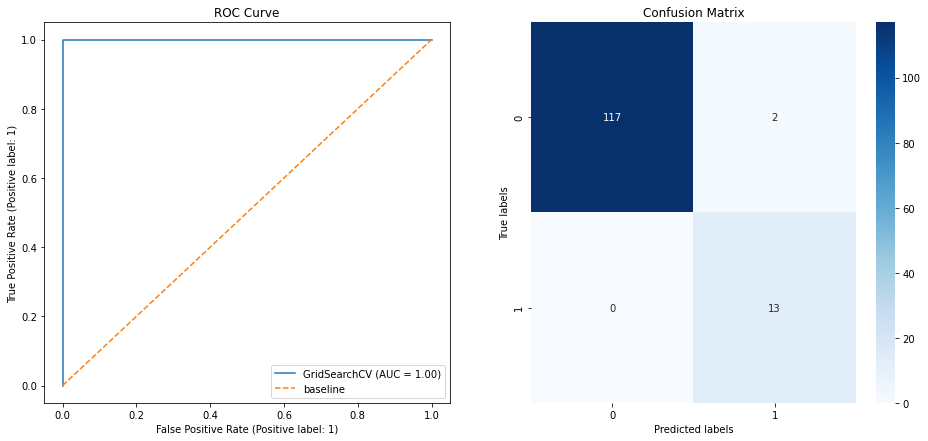

In [64]:
plot_model(clf, X_test_ss, y_test)

In [65]:
X_ss = ss.transform(X)
df_with_pred['prob_default'] = clf.predict_proba(X_ss)[:,1]

## Conclusion and Evaluation

In [66]:
df_with_pred['pred_repay'] = df_with_pred['prob_repay'].apply(lambda x: 0 if x < 0.5 else 1)

In [67]:
# save final submission file
df_submit = df_with_pred[['loan_id', 'pred_repay', 'pred_amount', 'prob_default']]
df_submit.to_csv('results/final_submission_file.csv')

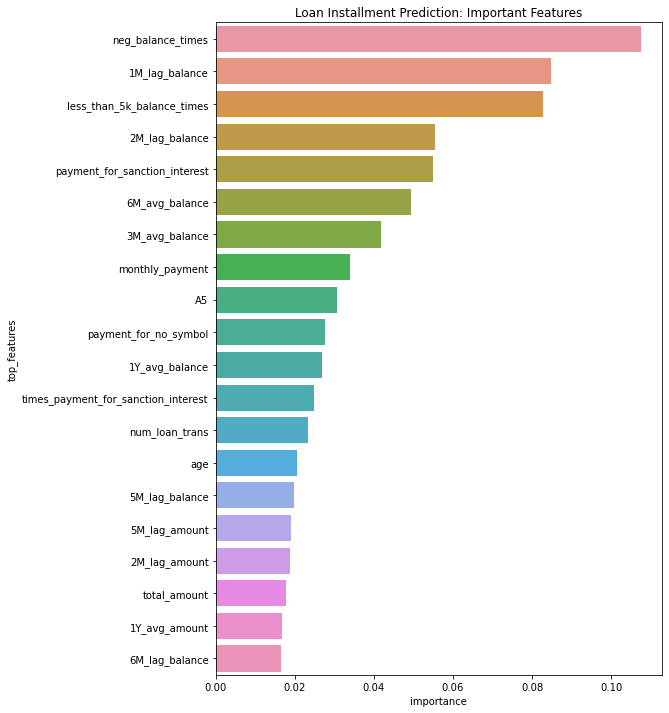

In [68]:
# Visualization
# plot features with the most importance
feat_weights = rf_best.feature_importances_
rf_names = df.drop(['status', 'prob_repay', 'pred_amount'], axis = 1).columns

rf_feat = pd.DataFrame( {'top_features': rf_names, 'importance' : feat_weights})
rf_feat = rf_feat.sort_values('importance',ascending = False)[:20]

plt.figure(figsize = (8,12))
plt.title('Loan Installment Prediction: Important Features')
sns.barplot(y='top_features', x='importance', data=rf_feat);

- The features that are most important in predicting whether or not a client will pay the monthly loan installment are the number of times the account has had a negative balance, the balance in the account 1 month ago, and the number of times the balance is less than 5K
- While most of the important features are related to the account balance, some other features include the payment for sanction interest (which makes sense since a client will be charged if their payment is late), the age of the client, and "A5" which is the number of municipalities with less than 500 people.

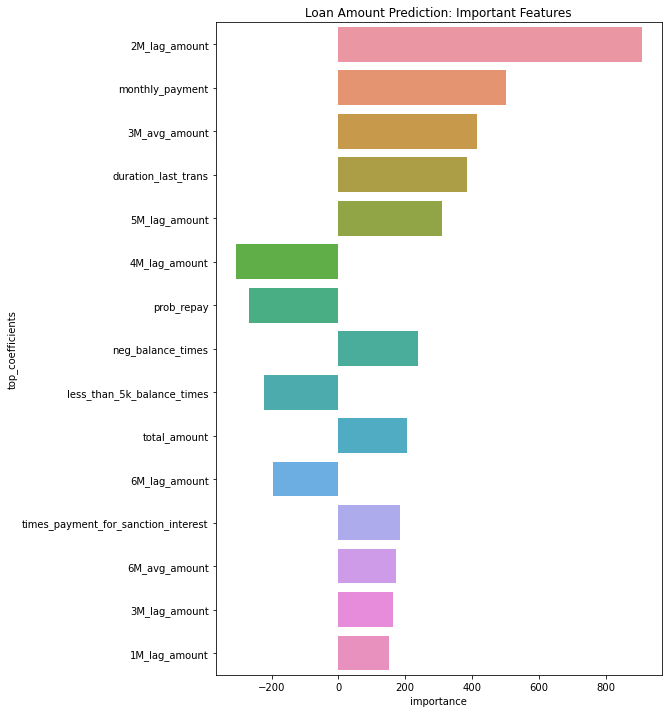

In [69]:
# Visualization
# plot coefficients with the most importance
feat_coef =  ridge_cv.coef_
feat_names = df_with_pred.drop(['loan_id', 'status', 'amount', 'not_paid', 'pred_amount', 'prob_default', 'pred_repay'], axis = 1).columns

lr_feat = pd.DataFrame( {'top_coefficients': feat_names, 'importance' : feat_coef})
lr_feat = lr_feat.reindex(lr_feat.importance.abs().sort_values(ascending = False).index)[:15]
plt.figure(figsize = (8,12))
plt.title('Loan Amount Prediction: Important Features')
sns.barplot(y='top_coefficients', x='importance', data=lr_feat);

- Most of the features are related to the averages or previous transaction amounts, which does make sense
- It is interesting that the amount 4 months and 6 months ago have a negative effect, while all the other amounts have a positive effect
- The probability that a client will pay the monthly loan instalment also has a negative relationship, so this was a useful feature to include in the model

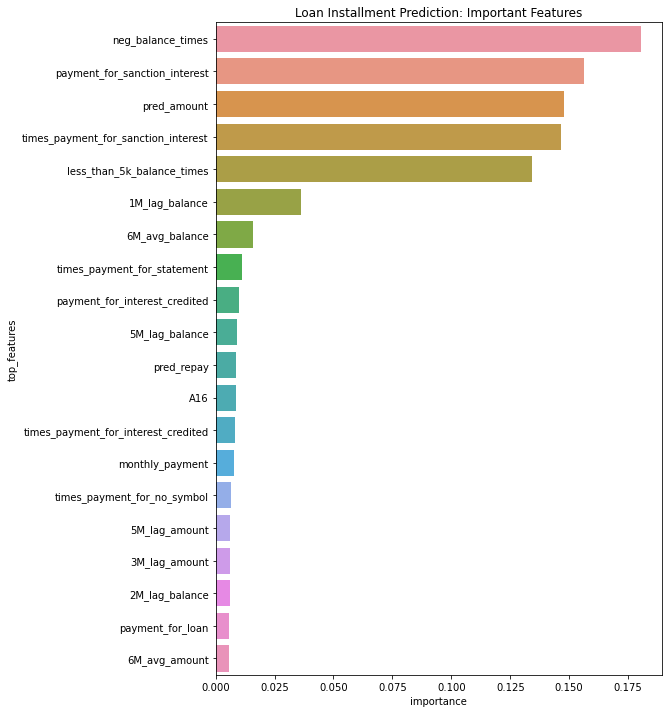

In [70]:
# Visualization
# plot features with the most importance
feat_weights = clf.best_estimator_.feature_importances_
clf_names = df_with_pred.drop(['loan_id', 'not_paid', 'status', 'amount', 'prob_repay', 'prob_default'], axis = 1).columns

clf_feat = pd.DataFrame( {'top_features': clf_names, 'importance' : feat_weights})
clf_feat = clf_feat.sort_values('importance',ascending = False)[:20]

plt.figure(figsize = (8,12))
plt.title('Loan Installment Prediction: Important Features')
sns.barplot(y='top_features', x='importance', data=clf_feat);

* The random forest model predicts that a client is in debt predominantly based on the following 5 features: the number of times the account has had a negative balance, the total payment amount for sanction interest (or the amount a client has paid in late fees) and the number of times the client has paid sanction interest, the predicted instalment amount a client will pay, and the number of times the balance in the account is less than 5K

In [71]:
df_with_pred.sum()[['amount', 'pred_amount']]

amount         1.723641e+06
pred_amount    1.733381e+06
dtype: float64

In [72]:
df_with_pred['amount'].sum()

1723641.3

In [73]:
df_with_pred['pred_amount'].sum()

1733381.267746862

In [74]:
print(f'Actual Amount for December 1998: {round(df_with_pred["amount"].sum(),3)}')
print(f'Predicted Amount for December 1998 assuming all clients pay: {round(df_with_pred["monthly_payment"].sum(),2)}')
print(f'Predicted Amount for December 1998 with model deployment: {round(df_with_pred["pred_amount"].sum(),2)}')

Actual Amount for December 1998: 1723641.3
Predicted Amount for December 1998 assuming all clients pay: 1785858.0
Predicted Amount for December 1998 with model deployment: 1733381.27


- The actual total amount clients repaid in December 1998 is 1,724K. If we assumed all clients paid the monthly instalment on schedule, we would have expected the total amount to be 1,786K. Therefore, the bank would have overestimated their cash position from client loans by 62K. 
- Instead, if the bank predicted which clients would pay the instalment on schedule using this model, we would have expected the total amount to be 1,733K. Therefore, the bank would have overestimated their cash position from client loans by 10K instead of 62K, which is a significant improvement.

## Further Steps

* In order to predict the total amount a client is able to pay over a given period, it would be interesting to look at a longer horizon, such as a prediction of how much a client will pay in a 3 month horizon. This could be more helpful in terms of predicting if a client will default, as typically at minimum a 90 day period with no payment would result in a loan being classified as non performing
* I used a threshold of 0.5 to determine if a loan instalment would be paid or not (i.e. if the model predicted that there was a 51% probability the client would pay the loan instalment, then the model would predict that the client paid the loan instalment for the month. However, for non performing loans, a bank may want to take a more conservative approach and use a higher threshold (i.e. the model should only predict that the client would pay the loan instalment if there was a 80% probability this would occur). Further analysis should be done to assess the optimal threshold for profit maximisation.
* The data set is quite small and there is a large class imbalance, which could contribute to why my models have a tendency to overfit the data. Collecting more loan data can help the model generalise better.